In [1]:
import timeit
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt

from skimage.filters import gaussian
import pyclesperanto_prototype as proto
import pyclesperanto as cle

cle.select_device()
cle.set_wait_for_kernel_to_finish(True)

proto.select_device()
proto.set_wait_for_kernel_finish(True)

sizes = np.arange(1, 200, 10)
sigma = 10

warmup_iter = 1
eval_iter = 3

seed_value = 42


In [2]:
def mb_to_bytes(mb:int = 1) -> int:
    return mb * 1024 * 1024

def shape_from_elements(bytes:int) -> tuple:
    elements = bytes / 4
    shape = int(np.power(elements, 1/3))
    return (shape, shape, shape)

def generate_random_image(size:int = 128) -> np.ndarray:
    """
    Generates a random image of given size and sigma.
    """
    shape = shape_from_elements(mb_to_bytes(size))
    return np.random.rand(shape[0], shape[1], shape[2]).astype(np.float32)

def benchmark_function(target_function, operation:str, framework:str) -> pd.DataFrame:
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    np.random.seed(seed_value)
    benchmark_data = []
    for size in sizes:
        # make new data
        image = generate_random_image(size)
        size_mb = image.size * image.itemsize / 1024 / 1024
        # bind target function to given image
        partial_function = partial(target_function, image, sigma)
        # warmup       
        _ = timeit.timeit(partial_function, number=warmup_iter)
        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=eval_iter)
        
        print(f"Processing {image.shape} of {size_mb} Mb with {framework}... {time_in_s} s")

        # store results
        benchmark_data.append(pd.DataFrame({"benchmark": operation, "framework": framework, "size": size_mb, "time": time_in_s}, index=[0]))
    return pd.concat(benchmark_data)

# Gaussian Blur

### pyclesperanto-prototype

In [3]:
def prototype_function(image, sigma):
    proto.gaussian_blur(source=image, sigma_x=sigma, sigma_y=sigma, sigma_z=sigma)

In [4]:
prototype_benchmark_data = benchmark_function(prototype_function, "gaussian_blur", "prototype")

Processing (63, 63, 63) of 0.9538536071777344 Mb with prototype... 0.0181333700002142 s
Processing (142, 142, 142) of 10.922576904296875 Mb with prototype... 0.15621459300018614 s
Processing (176, 176, 176) of 20.796875 Mb with prototype... 0.27192630799982 s
Processing (201, 201, 201) of 30.97763442993164 Mb with prototype... 0.4175746339988109 s
Processing (220, 220, 220) of 40.618896484375 Mb with prototype... 0.4995180129990331 s
Processing (237, 237, 237) of 50.78145217895508 Mb with prototype... 0.6609673599996313 s
Processing (251, 251, 251) of 60.3227653503418 Mb with prototype... 0.75210867900023 s
Processing (265, 265, 265) of 70.99008560180664 Mb with prototype... 1.0070029689995863 s
Processing (276, 276, 276) of 80.202392578125 Mb with prototype... 1.1411845130005531 s
Processing (287, 287, 287) of 90.17907333374023 Mb with prototype... 1.6187577999990026 s
Processing (298, 298, 298) of 100.95059204101562 Mb with prototype... 1.3236757810009294 s
Processing (307, 307, 307)

### pyclesperanto

In [5]:
def pycle_function(image, sigma):
    cle.gaussian_blur(input_image=image, sigma_x=sigma, sigma_y=sigma, sigma_z=sigma)

In [6]:
pycle_benchmark_data = benchmark_function(pycle_function, "gaussian_blur", "pyclesperanto")

Processing (63, 63, 63) of 0.9538536071777344 Mb with pyclesperanto... 0.012088633999155718 s
Processing (142, 142, 142) of 10.922576904296875 Mb with pyclesperanto... 0.15948540099998354 s
Processing (176, 176, 176) of 20.796875 Mb with pyclesperanto... 0.28148681000129727 s
Processing (201, 201, 201) of 30.97763442993164 Mb with pyclesperanto... 0.44027655300124025 s
Processing (220, 220, 220) of 40.618896484375 Mb with pyclesperanto... 0.5079703060000611 s
Processing (237, 237, 237) of 50.78145217895508 Mb with pyclesperanto... 0.6806588590006868 s
Processing (251, 251, 251) of 60.3227653503418 Mb with pyclesperanto... 0.765983994000635 s
Processing (265, 265, 265) of 70.99008560180664 Mb with pyclesperanto... 1.0848507680002513 s
Processing (276, 276, 276) of 80.202392578125 Mb with pyclesperanto... 1.2089951660000224 s
Processing (287, 287, 287) of 90.17907333374023 Mb with pyclesperanto... 1.8078464529990015 s
Processing (298, 298, 298) of 100.95059204101562 Mb with pyclesperanto

### Skimage

In [7]:
def skimage_function(image, sigma):
    gaussian(image, sigma)

In [8]:
skimage_benchmark_data = benchmark_function(skimage_function, "gaussian_blur", "scikit-image")

Processing (63, 63, 63) of 0.9538536071777344 Mb with scikit-image... 0.0805616130000999 s
Processing (142, 142, 142) of 10.922576904296875 Mb with scikit-image... 0.8656320699992648 s
Processing (176, 176, 176) of 20.796875 Mb with scikit-image... 1.67066988499937 s
Processing (201, 201, 201) of 30.97763442993164 Mb with scikit-image... 2.514309202999357 s
Processing (220, 220, 220) of 40.618896484375 Mb with scikit-image... 3.2595391769991693 s
Processing (237, 237, 237) of 50.78145217895508 Mb with scikit-image... 4.182405505000133 s
Processing (251, 251, 251) of 60.3227653503418 Mb with scikit-image... 4.98551179199967 s
Processing (265, 265, 265) of 70.99008560180664 Mb with scikit-image... 5.837515842998982 s
Processing (276, 276, 276) of 80.202392578125 Mb with scikit-image... 6.459059441000136 s
Processing (287, 287, 287) of 90.17907333374023 Mb with scikit-image... 7.488731903998996 s
Processing (298, 298, 298) of 100.95059204101562 Mb with scikit-image... 8.289277279000089 s


## Results

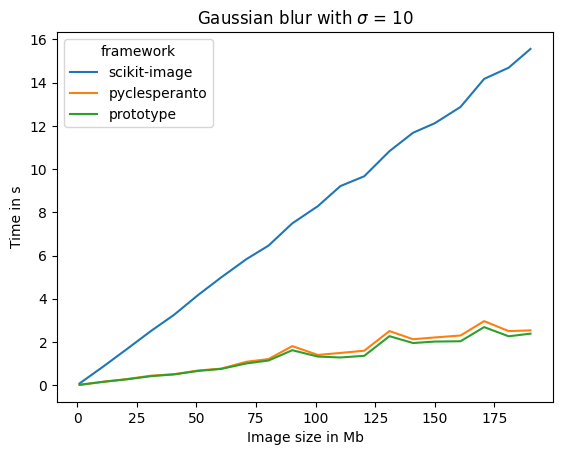

In [9]:
import seaborn as sns

bench = pd.concat([skimage_benchmark_data, pycle_benchmark_data, prototype_benchmark_data])

sns.lineplot(data=bench, x="size", y="time", hue="framework")
plt.title("Gaussian blur with $\sigma$ = 10")
plt.xlabel("Image size in Mb")
plt.ylabel("Time in s")
plt.show()